In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

#參考文章：https://www.kaggle.com/nishimoto/very-simple-linear-models-pls

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
testID = test['Id']

data = pd.concat([train.drop('SalePrice', axis=1), test], keys=['train', 'test'])
data.drop(['Id'], axis=1, inplace=True)

In [6]:
data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
train 0          60       RL         65.0     8450   Pave   NaN      Reg   
      1          20       RL         80.0     9600   Pave   NaN      Reg   
      2          60       RL         68.0    11250   Pave   NaN      IR1   
      3          70       RL         60.0     9550   Pave   NaN      IR1   
      4          60       RL         84.0    14260   Pave   NaN      IR1   

        LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
train 0         Lvl    AllPub    Inside      ...                 0        0   
      1         Lvl    AllPub       FR2      ...                 0        0   
      2         Lvl    AllPub    Inside      ...                 0        0   
      3         Lvl    AllPub    Corner      ...                 0        0   
      4         Lvl    AllPub       FR2      ...                 0        0   

        PoolQC Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
train 0    NaN   NaN         NaN       0       2    2008        WD   
      1    NaN   NaN         NaN       0       5    2007        WD   
      2    NaN   NaN         NaN       0       9    2008        WD   
      3    NaN   NaN         NaN       0       2    2006        WD   
      4    NaN   NaN         NaN       0      12    2008        WD   

         SaleCondition  
train 0         Normal  
      1         Normal  
      2         Normal  
      3        Abnorml  
      4         Normal  

[5 rows x 79 columns]

In [7]:
# Numerical features
# 剔除不必要的欄位
num_feats = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
             'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 
             'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
             'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
             'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
             'Fireplaces', 'FireplaceQu', 'GarageYrBlt',
             'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
             'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
             'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal',
             'YrSold','Electrical']    

# We need to convert literal grades to a numerical scale
grades = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
          'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
literal = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
num = [9, 7, 5, 3, 2]
G = dict(zip(literal, num))

data[grades] = data[grades].replace(G)

# Categorical features: everything that is not 'numerical'
cat_feats = data.drop(num_feats, axis=1).columns

# missing value selection
# I borrow code from
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
data["PoolQC"] = data["PoolQC"].fillna("None")
data["MiscFeature"] = data["MiscFeature"].fillna("None")
data["Alley"] = data["Alley"].fillna("None")
data["Fence"] = data["Fence"].fillna("None")
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])
#data = data.drop(['Utilities'], axis=1)
data["Functional"] = data["Functional"].fillna("Typ")
#data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])
data['MSSubClass'] = data['MSSubClass'].fillna("None")



In [8]:

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')

In [9]:
cat_feats

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir',
       'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence',
       'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

In [10]:
data.isnull().sum()[data.isnull().sum() > 0]

Utilities     2
Electrical    1
dtype: int64

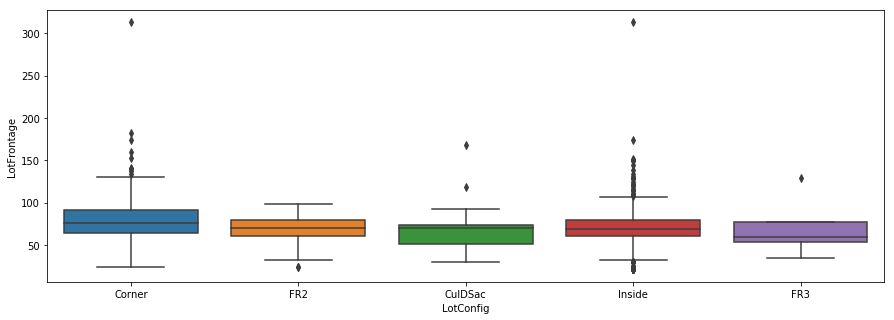

In [11]:
plt.subplots(figsize=(15,5))
boxdata = data.loc['train'].groupby('LotConfig')['LotFrontage'].median().sort_values(ascending=False)
order = boxdata.index
sns.boxplot(x='LotConfig', y='LotFrontage', order=order, data=data.loc['train'])

In [12]:
# Output.


In [13]:
data['LotFrontage'] = data['LotFrontage'].fillna(data.loc['train', 'LotFrontage'].median())

In [14]:
data['KitchenQual'].fillna(data['OverallQual'], inplace=True)

In [15]:

feats = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'Functional',
         'SaleType']
model = data.loc['train'].groupby('Neighborhood')[feats].apply(lambda x: x.mode().iloc[0])

for f in feats:
    data[f].fillna(data['Neighborhood'].map(model[f]), inplace=True)

In [16]:
data.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea    

In [17]:
data['MSSubClass'] = data['MSSubClass'].astype('object', copy=False)
data['MoSold'] = data['MoSold'].astype('object', copy=False)
data['BsmtFullBath'] = data['BsmtFullBath'].astype('int64', copy=False)
data['BsmtHalfBath'] = data['BsmtHalfBath'].astype('int64', copy=False)
data['GarageCars'] = data['GarageCars'].astype('int64', copy=False)
#data[years] = data[years].astype('int64', copy=False)

In [18]:
categorical_data = pd.concat((data.loc['train'][cat_feats], price), axis=1)

NameError: name 'price' is not defined

In [19]:
low = 0.05 * data.loc['train'].shape[0] # at least 5% of the dataset should have this value

for feat in cat_feats:        
    # we will group the categories based on the average sale price
    order = ((categorical_data.groupby(feat).mean()).sort_values(by='SalePrice', 
                                                      ascending=False).index.values.tolist())
    for i in range(0, len(order)):
        N = (categorical_data[categorical_data[feat] == order[i]]
             .count().max())
        j = i
        while (N < low) & (N != 0):
            j += 1

            if (j > len(order) - 1):
                # if reached the end of list, go back to last
                # useful category of the 'order' list
                j = i - 1
                break
            else: 
                N += (categorical_data[categorical_data[feat] == order[j]]
                      .count().max())
        if j < i:
            lim = len(order)
        else:
            lim = j

        for k in range(i, lim):
            categorical_data.replace({feat: {order[k]: order[j]}},
                                 inplace=True)
            data.replace({feat: {order[k]: order[j]}},
                                     inplace=True)            
    uniD = data[feat].unique()
    order = categorical_data[feat].unique()

    for i in uniD:
        if i not in order:
            ind = np.argsort(order - i)[0]
            data.replace({feat: {i: order[ind]}}, inplace=True)

NameError: name 'categorical_data' is not defined

In [20]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [21]:
# Remove columns with just one category


In [22]:
finaldata = pd.get_dummies(data)
bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath',
        'BsmtHalfBath', 
        'TotalBsmtSF']
fire = ['Fireplaces', 'FireplaceQu']
garage = ['GarageQual', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageCars', 
          'GarageArea', 'GarageYrBlt']
masn = ['MasVnrType', 'MasVnrArea']
others = ['Alley', 'Fence', 'PoolQC', 'MiscFeature']
black_list = bsmt + fire + garage + masn + others
for feat in finaldata.columns:
    if ('_0' in feat) and (feat.split("_")[0] in black_list):
        finaldata.drop(feat, axis=1, inplace=True)
finaldata.shape

(2919, 314)

In [23]:
# Training/testing sets
X_test = finaldata.loc['test']
X_train = finaldata.loc['train']
price = np.log1p(train['SalePrice'])
y_train = price
price.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [24]:
m = X_train.mean()
std = X_train.std()

X_train = (X_train - m) / std
X_test = (X_test - m) / std

data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
train 0         60       RL         65.0     8450   Pave  None      Reg   
      1         20       RL         80.0     9600   Pave  None      Reg   
      2         60       RL         68.0    11250   Pave  None      IR1   
      3         70       RL         60.0     9550   Pave  None      IR1   
      4         60       RL         84.0    14260   Pave  None      IR1   

        LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
train 0         Lvl    AllPub    Inside      ...                 0        0   
      1         Lvl    AllPub       FR2      ...                 0        0   
      2         Lvl    AllPub    Inside      ...                 0        0   
      3         Lvl    AllPub    Corner      ...                 0        0   
      4         Lvl    AllPub       FR2      ...                 0        0   

        PoolQC Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
train 0   None  None        None       0       2    2008        WD   
      1   None  None        None       0       5    2007        WD   
      2   None  None        None       0       9    2008        WD   
      3   None  None        None       0       2    2006        WD   
      4   None  None        None       0      12    2008        WD   

         SaleCondition  
train 0         Normal  
      1         Normal  
      2         Normal  
      3        Abnorml  
      4         Normal  

[5 rows x 79 columns]

In [25]:


# Create linear regression object
LR = LinearRegression()

# Train the model using the training sets
LR.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
maxcoef = np.argsort(-np.abs(LR.coef_))
coef = LR.coef_[maxcoef]
for i in range(0, 5):
    print("{:.<025} {:< 010.4e}".format(finaldata.columns[maxcoef[i]], coef[i]))

In [ ]:
model = [LR]
M = len(model)
CV = 5
score = np.empty((M, CV))
for i in range(0, M):
    score[i, :] = cross_val_score(model[i], X_train, y_train, cv=CV)

In [ ]:
print(score.mean(axis=1))

In [ ]:
finaldata = pd.get_dummies(data)
# Training/testing sets
X_test = finaldata.loc['test']
X_train = finaldata.loc['train']

#df_all_dummy = pd.get_dummies(data)
#df_train_dummy = df_all_dummy.loc[:len(df_train)]
#df_test_dummy = df_all_dummy.loc[len(df_train)+1:]

In [ ]:
# Convert to log score.
# by this process, I score up 0.02
y_log = np.log(price)
from sklearn.cross_decomposition import PLSRegression

# Main.
pls = PLSRegression(n_components=2)
pls.fit(X_train, list(y_log))
result = pls.predict(X_test)

#https://www.kaggle.com/nishimoto/very-simple-linear-models-pls
# Output.
result_list = []
for i in list(result):
    result_list.append(i[0])
pd.DataFrame({'Id': testID, "SalePrice": np.exp(result_list)}).to_csv("submission.pls.csv", index=False)

In [ ]:
# Create linear regression object
Rr = RidgeCV()

# Train the model using the training sets
Rr.fit(X_train, y_train)

In [ ]:
# Create linear regression object
Rr = RidgeCV()

# Train the model using the training sets
Rr.fit(X_train, y_train)

In [ ]:
maxcoef = np.argsort(-np.abs(Rr.coef_))
coef = Rr.coef_[maxcoef]
for i in range(0, 5):
    print("{:.<025} {:< 010.4e}".format(finaldata.columns[maxcoef[i]], coef[i]))

In [ ]:
# Create linear regression object
EN = ElasticNetCV(l1_ratio=np.linspace(0.1, 1.0, 5)) # we are essentially smashing most of the Rr model here

# Train the model using the training sets
train_EN = EN.fit(X_train, y_train)

In [ ]:
model = [LR, Rr,EN,pls]
M = len(model)
CV = 5
score = np.empty((M, CV))
for i in range(0, M):
    score[i, :] = cross_val_score(model[i], X_train, y_train, cv=CV)

In [ ]:
print(score.mean(axis=1))

In [ ]:
submit = pd.DataFrame({'Id': testID, 'SalePrice': np.exp(EN.predict(X_test))})
submit.to_csv('submission.csv', index=False)

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_train, label = price)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [ ]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, price)

In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
submit = pd.DataFrame({'Id': testID, 'SalePrice': xgb_preds})
submit.to_csv('submission.csv', index=False)